### Il est explicité ici l'utilisation des ensembles de codes écrits pour l'analyse de sensibilité sur des champs stochastiques et variables aléatoires.

### Il est d'abord conseillé d'installer l'environnement virtuel dont la définition se trouvent dans le fichier yaml

Nous allons faire ici l'analyse de sensiblité sur une poutre en flexion représentée par 100 éléments finis, et ou le module young et le diamètre de chaque élément est déterminé par un processus gaussien en une dimension. La position de la force, sa norme, tout comme la densité du matérieau sont déterminés par des lois nomales gaussiennes.
Dans la logique d'écriture de ces codes, il faut avoir un à priori sur les processus gaussiens, la loi qu'ils suivent, tout comme sur les paramètres des lois gaussiennes. Ensuite, il faut avoir une fonction python qui prend en entrée ces champs, et qui renvoie un ensemble connu de resultas. 


In [1]:
try:
    import anastruct, openturns, numba, joblib
except:
    import os
    if os.sys.platform == 'linux' :
        file_path = 'sensitivityEnv.yml'
        os.system('conda env create -f'+file_path)
        # to have the right modules installed
        print('now activate the environment and restart jupyter with other kernel')
    else :
        print('Do it alone')

In [2]:
import sys
sys.path.insert(0, '../')
# Voici les deux scripts destinés à gérer l'analyse de sensibilité sur les champs stochastiques
import StochasticProcessSensitivity as SPS
import StochasticProcessConstructor as SPC
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 
# on importe aussi les fonctions à étudier
import RandomBeamGenerationClass    as rbgc

D'abord, nous définisson l'ensemble de nos variables d'entrée, tout comme les variables de sortie :
- L'on va définir un par un tout les processus et variables aléatoires utilisées dans notre model. Bien sûr cela implique d'avoir un à-priori sur le comportement de ces différentes lois probabilistes. 
- Néanmoins, comme nous en sommes à des codes d'essai, il serait assez trivial de rajouter la prossiblité de récuperer l'approximation d'un champ inconnu avec l'approcimation de Karhunen - Loeve, en présence d'un grand nombre de mesures.
- La définition des éléments sur lesquels est construit le champ stochastique est un peu différent de la manière interne à openturns. En effet, s'étant placés directement dans un cadre de poutre en 'éléments finis, ou l'on a N+1 noeuds (N étant le nombre de poutres), il faut savoir si N est le nombre de mailles ou le nombre de noeuds. Dans le choix a été fait ici de définir la taille du maillage (grid_shape) de la manière suivante :
> grid_shape = [[position_X0, longeur_totaleX, nombre_mailles], [position_Y0, longeur_totaleY, nombre_mailles], ..]
 

In [3]:
# process governing the young modulus for each element (MPa)
process_E = SPC.StochasticProcessConstructor(dimension=1,
                                        grid_shape=[[0,1000,100],],
                                        covariance_model={'Model':'MaternModel',
                                                        'amplitude':[50000],
                                                        'scale':[300],
                                                        'nu':13/3},
                                        trend_arguments=['x'],trend_function=210000)
process_E.setName('E_')


# process governing the diameter for each element (mm) 
# other constructor shown 
process_D = SPC.StochasticProcessConstructor()
process_D.setDimension(1)
process_D.setGrid([[0,1000,100],])
#setCovarianceModel also accepts any of the models defined in openturns, already initialised
#with the right parameters, not only dictionaries
process_D.setCovarianceModel(covarianceModelDict = {'Model':'MaternModel',
                                                    'amplitude':[.3],
                                                    'scale':[250],
                                                    'nu':7.4/3})
process_D.setTrend(['X'], 10)
process_D.setName('D_')

# random variable for the density of the material (kg/m³)
rho         = 7850.
sigma       = 750
nameD       = 'Rho'
RV_Rho = ot.Normal(rho, sigma)
RV_Rho.setName(nameD)

# random variable for the position of the force   (mm) 
middle       = 500
sigma_f      = 50
namePos     = 'FP'
RV_Fpos = ot.Normal(middle, sigma_f)
RV_Fpos.setName(namePos)

# random variable for the norm of the force    (N)
muForce       = 100
# we go from sigma = 15 to sigma = 1.5, as the influence is too important
sigma_Fnor    = 5.5
nameNor       = 'FN'
RV_Fnorm  = ot.Normal(muForce, sigma_Fnor)
RV_Fnorm.setName(nameNor)

Assessing the right constructor choice from input dictionary for MaternModel
Choosen constructor is: ( scale, amplitude, nu ) =>  [[300], [50000], 4.333333333333333]
trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
Assessing the right constructor choice from input dictionary for MaternModel
Choosen constructor is: ( scale, amplitude, nu ) =>  [[250], [0.3], 2.466666666666667]
trend function args:  ['X']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


Il est important de noter que les processus et variables aléatoires doivent être définies à partir du module 
NdGaussianProcessConstructor, qui contient les classes suivantes : 
###### Classe pour construire un champ stochastique : 
> NdGaussianProcessConstructor.NdGaussianProcessConstructor() 
###### Classe pour construire une variables aléatoire  : 
> NdGaussianProcessConstructor.NormalDistribution() ## Classe openturns.Normal() suchargée
###### Classe pour construire un vecteur de variables aléatoires normales : 
> NdGaussianProcessConstructor.RandomNormalVector() ## Classe openturns.PythonRandomVector surchargée. Cette dernière est utilisée en interne par NdGaussianProcessConstructor.

**Finalement, l'autre particularité du NdGaussianProcessConstructor, est d'utiliser un objet _numpy.memmap_ modifiée, qui enregistre les échantillons de processus gaussiens sous forme de fichier temporaire dans le directoire d'utilisation des codes et les éfface en sortant du code**

L'on définit ensuite les variables de sortie. Il faut connaître l'ordre dans lequel la fonction renvoie ses resultats connaitre leur nom comme leur dimension. 
    

In [4]:
from importlib import reload
reload(SPS)
outputVariables = {'out1' :
                   {
                         'name'     : 'VonMisesStress',
                         'position' : 0,
                         'shape'    : (102,)  
                    },
                   'out2' :
                   {
                        'name'      : 'maxDeflection',
                        'position'  : 1,
                        'shape'     : (1,)
                   }
                  }
#Pour utiliser notre fonction, un wrapper a été spécialement écrit pour faciliter l'accès aux fonctions mais
#ce choix est entièrement dépendant de la manière dont a été définie la fonction sur laquelle vous travaillez.
functionWrapper = rbgc.sampleAndSoloFunctionWrapper(process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm)

###### Ensuite, on crée une instance pour l'analyse de sensibilité.
Il faut donner en entrée une liste contenant les procéssus et les variables aléatoires **dans l'ordre** dans lequel la fonction les recoit. 

*Pour cela il faut aussi connaître l'ordre des variables d'entrée de la fonction et leur nombre.*

**Ces fonctions sont celles qui prennent entrée des champs aléatoires (vecteurs et matrices, de type *list ou numpy*) et variables aléatoire (scalaires (vecteurs 1D pour le multiprocessing)) et non pas les fonctions prennant en entrée les variables aléatoires issues de la décomposition de la Karhunen Loeve, qui elles sont construites en interne dans la classe**

In [5]:
inputVarList = [process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm]
# We also the need the two functions of the model (one for samples, the other for single evaluations)
# In our case, as our model is defined as a class, we have to first create the model, 
# but it also could just be just two functions taking as an input the fields and RVs
soloFunction   = functionWrapper.randomBeamFunctionSolo
sampleFunction = functionWrapper.randomBeamFunctionSample
##
size           = 50 ## Number of samples for our sobol indicies experiment (kept low here to make things faster)
##
reload(SPS)
## It is sufficient just to pass one of the functions 
processSensitivityAnalysis = SPS.StochasticProcessSensitivityAnalysis(inputVarList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 E_ D_ Rho FP FN 

Output Variables are :
 ['VonMisesStress', 'maxDeflection'] 

Composed distribution built with processes and distributions: E_; D_; Rho; FP; FN
Program initialised, ready for sensitivity analysis. You can now proceed to prepare the Sobol indices experiment



Voici une vue du dictionnaire intermédiaire qui est crée une fois les processus et variables aléatoires d'entrées définies :

On voit que la position des processus dans les arguments de la fonction d'entrée est enregistrée dans le dictionnaire dans la clé *position* et viennent de la manière de laquelle on a mis les VA et Processus dans le vecteur inputVarList. 


###### Ensuite, grace à l'intermédiaire de la classe ot.SobolIndiciesExperiment, on génère les' variables aléatoires d'entrée 

In [6]:
processSensitivityAnalysis.run(generationType = 1)


Generation types are:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
You choose Random generation
number of samples for sobol experiment =  350 

input design shape is:  (350, 24)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

shape deflection:  (350, 103)  should be [N,10X] something
deflection std deviation  7.110938768496824
Converting list of outputs into matrix...
Output variable 1 has shape (350, 102)
Output variable 2 has shape (350,)
Final matrix shape: (350, 103)
Columns where nan :  [] 


No errors while processing, the function has returned no np.nan.



[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   22.9s finished


###### Ensuite on récupère les sorties associées aux entrées génerées. 
L'idée du postprocessing est d'identifier si dans les sorties il y a des valeurs de type np.nan, et de refaire les experiences manquantes tant qu'il y a des np.nan de présents.

**Ceci crée quelques problèmes : En effet, si le calcul numérique n'a pas pu aboutir avec une certaine réalisation des variables en entrée, est-ce que cela veut dire que cette réalisation est défaillante? Va-t-on l'inclure dans le cas du calcul de la défaillance ou de la sensibilité? Car si on l'inclut pas, il se peut qu'on oublie un nombre conséquent de modes défaillants. Solution : changer le modèle informatique et le rendre robuste à ces erreurs, ou faire une étude précise avec ces réalisation particulières.**


La solution retenue pour génerer les experiences manquantes est d'itérer au dessus de chaque index de la sortie ou se trouvent les nans, de refaire une experience de sobol de taille 1 ( donc qui renverra d+2 valeurs, avec d la dimension de l'entrée), de générer les sorties correspondant aux entrées (recommencer si il s'y trouve un np.nan), et de remplacer les d+2 valeurs du inputDesign d'entrée avec celles que l'on vient de regénérer. 

Le *timing* vient de la classe ***custum_wraps***, qui est pour l'instant assez inutile, mais permet de prendre en main les décorateurs...

Une fois le _output design_ generé, l'on peut faire l'analyse de sensibilité sur le model.
Pour ce faire, l'on utilise la fonction ***self.getSobolIndiciesKLCoefs***.
La fonction ne renvoie pas directement les indices de sobol, mais bien des champs d'objets ***openTURNS.SaltelliSensitivityAlgorithm*** ou ***openTURNS.MartinezSensitivityAlgorithm*** ou ***openTURNS.JansenSensitivityAlgorithm*** ou ***openTURNS.MauntzKucherenkoSensitivityAlgorithm***.

Ceci est bien sûr fait dans l'optique de toujours pouvoir accéder à l'entierté des indices de sobol et indices totaux du modèle.
Ceci veut aussi dire qu'il manque une dimension pour les champs en sortie, celle des variables d'entrée.

Ici on calcule les indices de sobol du premier ordre

In [8]:
processSensitivityAnalysis.getSensitivityAnalysisResults()

You have chosen to use the Saltelli method
There are 2 distinct outputs
Implicit dimension = 5
Implicit description: [X0,X1,X2,X3,X4]
There are 5 indices to get in (102,) dimensions with 102 elements
basic output shape is: (50, 102)
output reshaped into matrix of shape (dim<=2)  [50, 102]
data for variance calculus prepared 
 X_fo shape is (50, 102) Y_fo shape is (50, 102) 

Variance ND is: [0.00958383 0.00828492 0.0087516  0.00939705 0.01018164 0.01110133
 0.01214819 0.01330526 0.01454586 0.01583497 0.01713223 0.01839598
 0.01958775 0.02067597 0.02163834 0.02246225 0.02314345 0.02368362
 0.02408732 0.02435911 0.02450109 0.02451111 0.0243819  0.02410127
 0.02365369 0.02302325 0.02219791 0.02117433 0.01996215 0.01858632
 0.01708666 0.01551436 0.01392664 0.01238088 0.01092973 0.00961774
 0.0084792  0.00753687 0.00680102 0.00626904 0.00587629 0.00573705
 0.00541826 0.00548224 0.00661553 0.00842481 0.00973597 0.01144594
 0.01303367 0.01188672 0.00898187 0.00974971 0.01459836 0.01940236
 0.

Variance ND is: [0.11262425 0.12221503 0.1223838  0.12192324 0.12105144 0.11976673
 0.11807203 0.11600026 0.11361564 0.11100736 0.10828174 0.10555596
 0.10295374 0.10060008 0.09861184 0.09708289 0.09606611 0.09555797
 0.09549221 0.09574748 0.09617022 0.09660992 0.09695992 0.09719473
 0.09739374 0.09774265 0.09850724 0.09998032 0.10241026 0.10592759
 0.11049119 0.11587315 0.12169133 0.12748303 0.13279941 0.13729405
 0.14078316 0.14326561 0.1449037  0.14597529 0.14681341 0.14759816
 0.15122929 0.15488634 0.1491887  0.15231728 0.14889177 0.15538606
 0.17137091 0.19427179 0.2360755  0.21500289 0.20069258 0.177952
 0.17418849 0.16977677 0.15157158 0.13515219 0.12127802 0.11185512
 0.10906945 0.11048726 0.12209606 0.13758132 0.13814599 0.13803587
 0.13713267 0.13544151 0.13309472 0.13033609 0.12748888 0.12491289
 0.12295667 0.12191119 0.12197051 0.12320433 0.12554637 0.12880066
 0.13266553 0.13677212 0.14073134 0.14418152 0.14682867 0.14847335
 0.14902113 0.14847776 0.14693287 0.14453743 0.1

L'on peut récuperer ces indices du premier ordre dans ***self.processSensitivityAnalysis.sensitivityResults.firstOrderIndices***
Matplotlib permet de facilement visualiser ces indices. Néanmoins, cette visualisation est pour l'instant peu pertinente, puisque l'on visualise chaque variables aléatoire de Karhunen Loeve individuellement, alors qu'il nous faut encore combiner ces dernières pour que l'indice de sobol soit représentatif du champ stochastique consideré.

half of the length of the symetric confidence interval 
half of the length of the symetric confidence interval 
The output is a vector


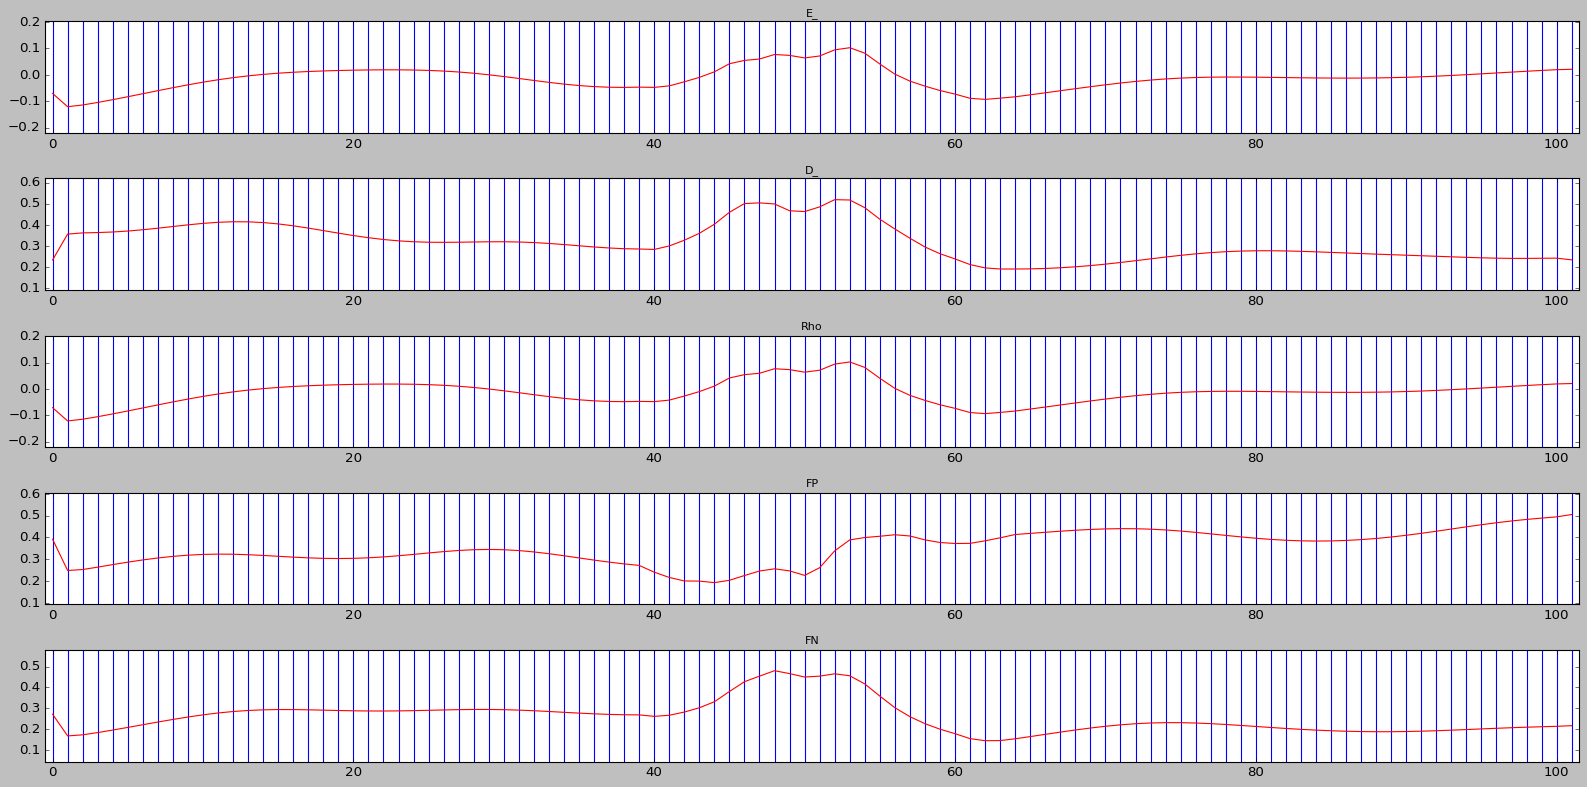

In [11]:
processSensitivityAnalysis.SensitivityAnalysisResults['VonMisesStress'].draw()

half of the length of the symetric confidence interval 
half of the length of the symetric confidence interval 
The output is scalar
The sensitivity is measured accordingly to the 5 input variables, namely:
 E_ and D_ and Rho and FP and FN


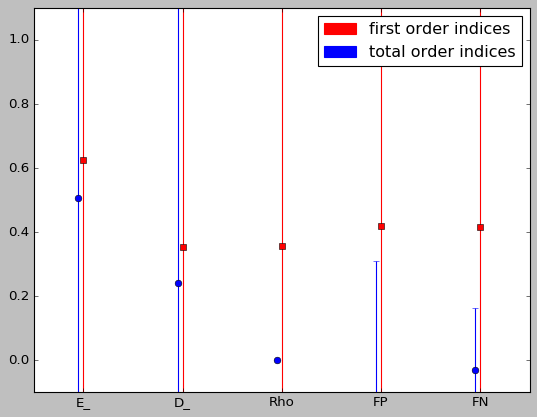

In [12]:
processSensitivityAnalysis.SensitivityAnalysisResults['maxDeflection'].draw()